#  ARMA Prediction with a Kalman filter

In [1]:
import ssm

In [16]:
import jax
import einops
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [3]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
# plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["figure.figsize"] = (7.2, 3.0)


In [4]:
%load_ext autoreload
%autoreload 2

## The Kalman filter and predictions

In [5]:
@partial(jax.jit, static_argnames=("k",))
def forecast_mean(F, mu, k):
    """
    Following Proposition 2.2 in F.02
    """
    def _step(mu, _):
        mu_next = F @ mu
        return mu_next, mu_next
    steps = jnp.arange(k)
    _, mu_pred = jax.lax.scan(_step, mu, steps)
    return mu_pred


@partial(jax.jit, static_argnames=("k",))
def forecast_cov(F, Sigma, Q, k):
    """
    Following Proposition 2.3 in F.02
    """
    def _step(state, _):
        Sigma_mult, dynamics_carry, F_mult = state

        dynamics_carry = dynamics_carry + F_mult @ Q @ F_mult.T
        F_mult = F @ F_mult        
        Sigma_mult = F @ Sigma_mult @ F.T

        Sigma_pred = Sigma_mult + dynamics_carry
        
        state_next = (Sigma_mult, dynamics_carry, F_mult)
        return state_next, Sigma_pred
    steps = jnp.arange(k)
    dim_state = len(Q)
    state_init = (Sigma, jnp.zeros((dim_state, dim_state)), F)
    _, Sigma_pred = jax.lax.scan(_step, state_init, steps)
    return Sigma_pred

In [6]:
def kf_step(bel, y, H, F, R, Q, n_forecast):
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # innovation
    S = H @ Sigma_pred @ H.T + R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - H @ mu_pred # innovation

    # Update
    mu_update = mu_pred + K @ err
    Sigma_update = Sigma_pred - K @ S @ K.T
    bel_next = (mu_update, Sigma_update)

    out = {
        "mu": mu_update,
        "err": err,
        "yhat": H @ mu_update,
        "mu_forecast": forecast_mean(F, mu_update, n_forecast),
    }

    return bel_next, out

## Defining the ARMA process

In [55]:
key = jax.random.PRNGKey(3141)

In [65]:
ma_n = 10
H_ma = jnp.ones(10) * 0.5
H_ar = jnp.ones(2) * 0.1
# H, F, T = ssm.init_arma_components(H_ma=H_ma)
H, F, T = ssm.init_arma_components(H_ar=H_ar, H_ma=H_ma)
# H, F, T = ssm.init_arma_components(H_ar=H_ar)
dim_state = len(H)
# R = jnp.eye(1) * 1.0 ** 2
R = jnp.eye(1) * 1.0 ** 2

In [154]:
n_steps = 80
n_test = 20
steps = jnp.arange(n_steps)
sample = ssm.sample_ssm(key, F, H, T, R, n_steps + n_test)

test = jax.tree.map(lambda x: x[-n_test:], sample)
sample = jax.tree.map(lambda x: x[:-n_test], sample)

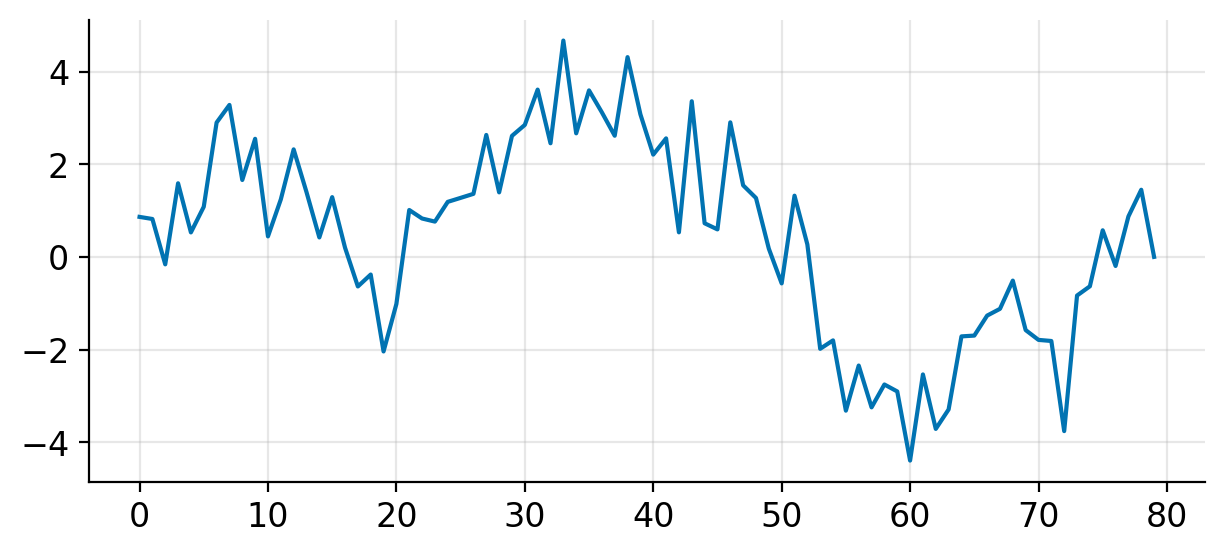

In [155]:
plt.plot(sample["y"])
plt.grid(alpha=0.3)

In [156]:
Q = T @ R @ T.T
n_forecast = 10
_step = partial(kf_step, H=H[None, :], F=F, R=R, Q=Q, n_forecast=n_forecast)
y = sample["y"]

mu_init = jnp.zeros(dim_state)
Sigma_init = jnp.eye(dim_state)
bel_init = (mu_init, Sigma_init)

(mu, Sigma), hist = jax.lax.scan(_step, bel_init, y[:, None])

In [157]:
filter_hist = jnp.einsum("i,ti->t", H, hist["mu"])

In [158]:
jnp.sqrt(jnp.power(hist["err"], 2).mean())

Array(1.1432916, dtype=float32)

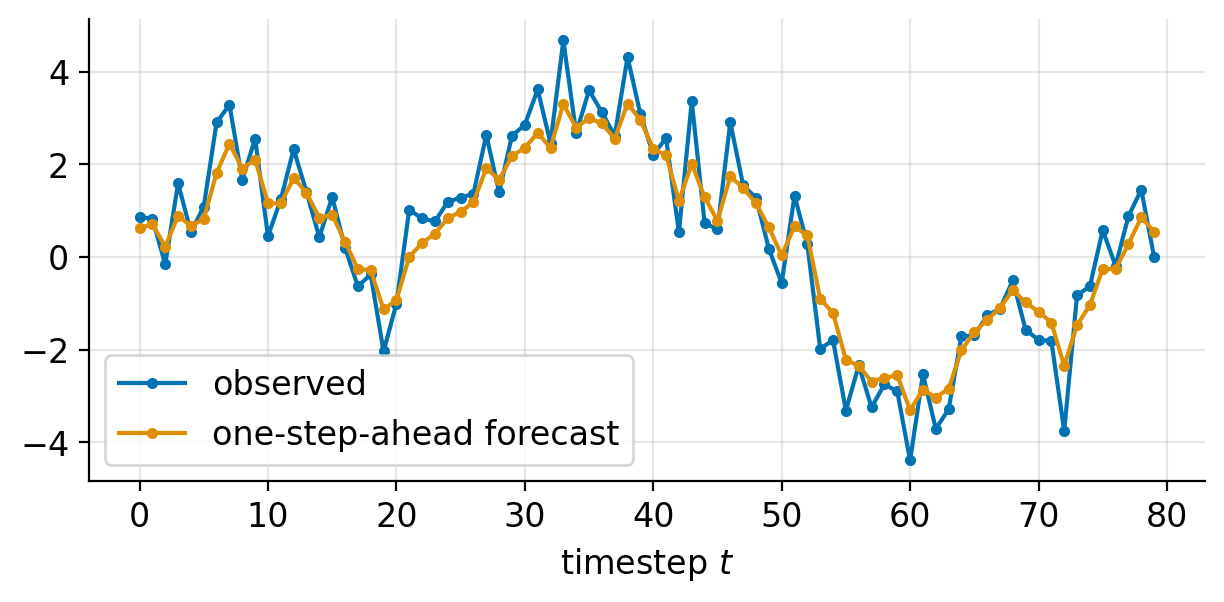

In [159]:
plt.plot(sample["y"], marker="o", markersize=3, label="observed")
plt.plot(hist["yhat"], marker="o", markersize=3, label="one-step-ahead forecast")
plt.legend()
plt.xlabel("timestep $t$")
plt.grid(alpha=0.3)

In [160]:
mu_hist = hist["mu_forecast"]
mu_prev = hist["mu"]
mu_hist, ps = einops.pack([mu_prev, mu_hist], "time * dim")

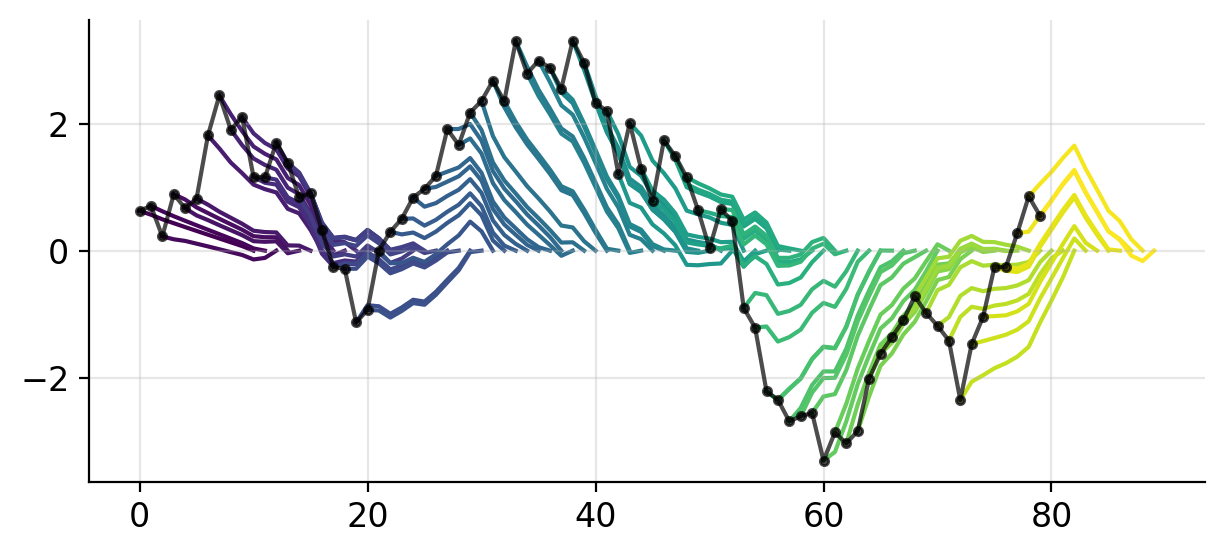

In [164]:
pred_ahead = jnp.einsum("m,skm->sk", H, mu_hist)
steps_ahead = jnp.arange(n_steps)[:, None] + jnp.arange(n_forecast + 1)[None, :]

# plt.plot(sample["y"], marker="o", markersize=3, label="observed")

colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
plt.plot(hist["yhat"], marker="o", markersize=3, label="one-step-ahead forecast", c="black", alpha=0.7)
colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
for color, k_steps, k_pred in zip(colors, steps_ahead, pred_ahead):
    # plt.plot(k_steps, k_pred, c="gray", alpha=0.5)
    # plt.scatter(k_steps[0], k_pred[0], facecolor=color, s=20, edgecolor="black")
    plt.plot(k_steps, k_pred, c=color, alpha=1.0, zorder=0)
# plt.xlim(0, 60)
plt.grid(alpha=0.3)

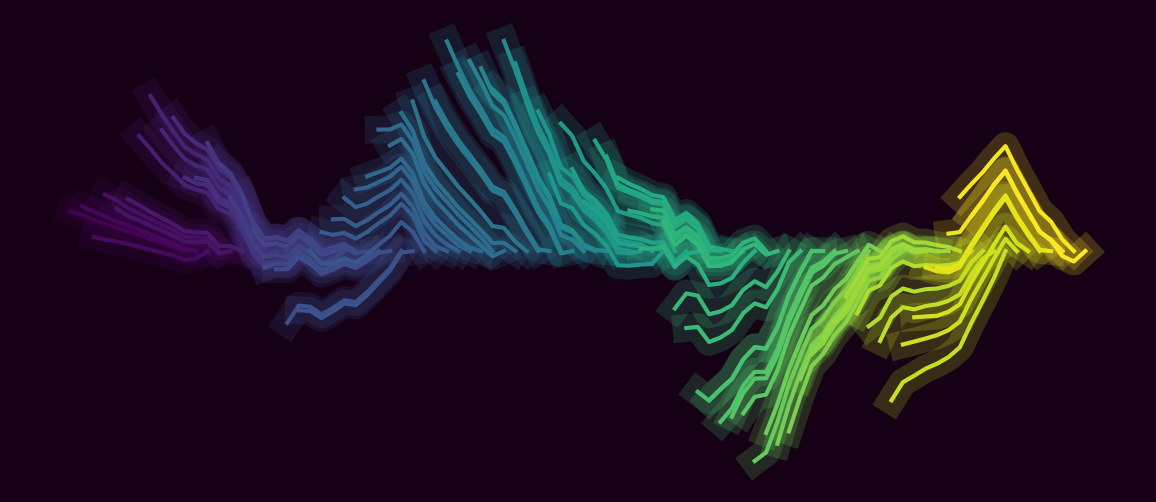

In [166]:
pred_ahead = jnp.einsum("m,skm->sk", H, mu_hist)
steps_ahead = jnp.arange(n_steps)[:, None] + jnp.arange(n_forecast + 1)[None, :]

# plt.plot(sample["y"], marker="o", markersize=3, label="observed")
# plt.plot(hist["yhat"], marker="o", markersize=3, label="one-step-ahead forecast", c="black", alpha=0.7)

fig, ax = plt.subplots(facecolor="#150015")
colors = plt.cm.viridis(jnp.linspace(0, 1, n_steps))
for color, k_steps, k_pred in zip(colors, steps_ahead, pred_ahead):
    # plt.plot(k_steps, k_pred, c="gray", alpha=0.5)
    plt.plot(k_steps, k_pred, c=color, alpha=1.0, zorder=0)
    plt.plot(k_steps, k_pred, c=color, zorder=0, linewidth=10, alpha=0.2)
plt.grid(alpha=0.3)
plt.axis("off")
# plt.savefig("./arma-forecast.png", dpi=300, bbox_inches="tight")

## Predictions

In [112]:
mu_pred = forecast_mean(F, mu, n_test)
y_pred = jnp.einsum("d,td->t", H, mu_pred)

In [113]:
Sigma_pred = forecast_cov(F, Sigma, Q, n_test)
std_pred = jnp.sqrt(jnp.einsum("sij,i,j->s", Sigma_pred, H, H))

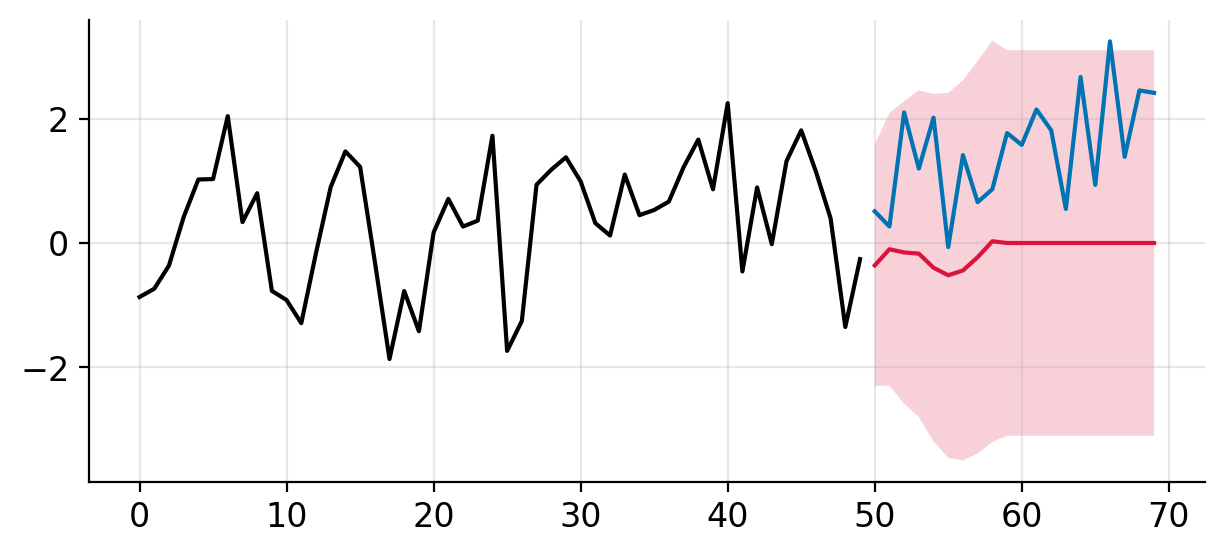

In [114]:
steps_pred = jnp.arange(n_test) + n_steps
# plt.plot(steps, hist["yhat"], c="black")
plt.plot(steps, sample["y"], c="black")
plt.plot(steps_pred, y_pred, c="crimson")
plt.plot(steps_pred, test["y"])
plt.fill_between(
    steps_pred, y_pred - 2*  std_pred, y_pred + 2 * std_pred,
    edgecolor="none",  facecolor="crimson", alpha=0.2
)
plt.grid(alpha=0.3)

## Refernces

1. https://proceedings.mlr.press/v30/Anava13.html